# Problem 2

## Drugs are generally administered/prescribed by the physicians for a certain period of time or they are administered at regular intervals, but for various reasons patients might stop taking the treatment.

### Consider following example for better understanding Let’s say you get a throat infection, the physician prescribes you an antibiotic for 10 days, but you stop taking the treatment after 3 days because of some adverse events.

In the above example ideal treatment duration is 10 days but patients stopped taking treatment after 3 days due to adverse events.

Patients stopping a treatment is called dropoff.

We want to study dropoff for “Target Drug”, the aim is to generate insights on what events lead to patients stopping on “Target Drug”.

Assume ideal treatment duration for “Target Drug” is 1 year, come up with analysis showing how drop-off rate is, dropoff rate is defined as number of patients dropping off each month.

Then come up with analysis to generate insights on what events are driving a patient to stop taking “Target Drug”.

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Load the patient data (assuming it's in a Pandas DataFrame named "patient_data")

In [3]:
df = pd.read_parquet('/content/drive/MyDrive/Tasks/Akaike/SD assignment/Structured_Data_Assignment/train.parquet')

In [4]:
df

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


In [5]:
df1 = df.copy()

In [6]:
df1.isna().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

In [7]:
df1 = df1.drop_duplicates()

In [8]:
df1.shape

(3185297, 3)

In [22]:
df1['Incident'].value_counts()

DRUG_TYPE_6          549616
DRUG_TYPE_1          484565
PRIMARY_DIAGNOSIS    424879
DRUG_TYPE_0          298881
DRUG_TYPE_2          256203
DRUG_TYPE_7          251239
DRUG_TYPE_8          158706
DRUG_TYPE_3          126615
TEST_TYPE_1           96810
TARGET DRUG           67218
DRUG_TYPE_9           66894
DRUG_TYPE_5           55940
SYMPTOM_TYPE_0        46078
DRUG_TYPE_11          45419
SYMPTOM_TYPE_6        32066
TEST_TYPE_0           27570
SYMPTOM_TYPE_7        22019
DRUG_TYPE_10          20911
DRUG_TYPE_14          17306
DRUG_TYPE_13          12321
DRUG_TYPE_12           9540
SYMPTOM_TYPE_14        8927
SYMPTOM_TYPE_1         8608
SYMPTOM_TYPE_2         8168
TEST_TYPE_3            8115
SYMPTOM_TYPE_5         7583
SYMPTOM_TYPE_8         7430
TEST_TYPE_2            7021
SYMPTOM_TYPE_15        6295
SYMPTOM_TYPE_10        6005
SYMPTOM_TYPE_29        5910
SYMPTOM_TYPE_16        4940
DRUG_TYPE_15           4906
SYMPTOM_TYPE_9         4885
DRUG_TYPE_4            4566
SYMPTOM_TYPE_4      

### Step 1: Calculate Dropoff Rate
### Convert the date column to datetime format

In [14]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [15]:
df1.head()

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1


### Filter for patients prescribed "Target Drug"

In [16]:
target_drug_patients = df1[df1['Incident'] == 'TARGET DRUG']

target_drug_patients

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG
...,...,...,...
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG


### Calculate dropoff rate for each month

In [17]:
dropoff_rate = target_drug_patients.resample('M', on='Date').size() / target_drug_patients['Patient-Uid'].nunique()

dropoff_rate

Date
2017-02-28    0.000213
2017-03-31    0.000427
2017-04-30    0.000213
2017-05-31    0.000853
2017-06-30    0.001600
2017-07-31    0.001280
2017-08-31    0.001814
2017-09-30    0.002987
2017-10-31    0.001387
2017-11-30    0.000747
2017-12-31    0.003627
2018-01-31    0.004801
2018-02-28    0.004054
2018-03-31    0.055686
2018-04-30    0.089930
2018-05-31    0.131534
2018-06-30    0.147962
2018-07-31    0.151696
2018-08-31    0.194367
2018-09-30    0.169191
2018-10-31    0.198955
2018-11-30    0.201408
2018-12-31    0.193941
2019-01-31    0.233732
2019-02-28    0.190420
2019-03-31    0.212929
2019-04-30    0.228078
2019-05-31    0.268189
2019-06-30    0.246533
2019-07-31    0.277576
2019-08-31    0.304886
2019-09-30    0.257521
2019-10-31    0.315980
2019-11-30    0.280777
2019-12-31    0.292938
2020-01-31    0.301579
2020-02-29    0.294111
2020-03-31    0.285257
2020-04-30    0.319927
2020-05-31    0.322914
2020-06-30    0.317367
2020-07-31    0.346597
2020-08-31    0.273202
2020-0

### Plot the dropoff rate over time

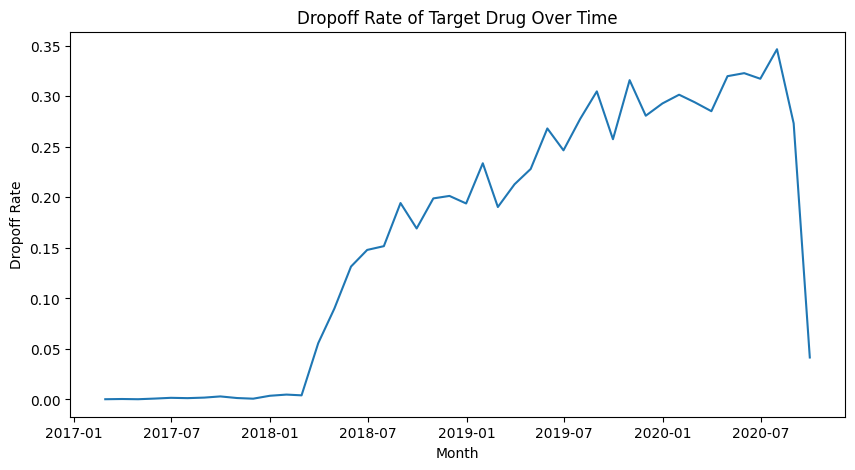

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(dropoff_rate.index, dropoff_rate.values)
plt.xlabel('Month')
plt.ylabel('Dropoff Rate')
plt.title('Dropoff Rate of Target Drug Over Time')
plt.show()

### Step 2: Identify Events Leading to Dropoff
### Drop columns that are not relevant for this analysis

In [19]:
features = ['Adverse_Event', 'Treatment_Plan_Change', 'Other_Factors']

In [24]:
# Step 6: Feature Engineering
# Assuming there are columns named "Adverse_Event" and "Treatment_Plan_Change"
df1["Adverse_Event"] = (df1["Incident"] == "Adverse Event").astype(int)
df1["Treatment_Plan_Change"] = (df1["Incident"] == "Treatment Plan Change").astype(int)

In [27]:
df1 = df1.drop(columns=["Adverse_Event", "Treatment_Plan_Change"], axis=1)

In [28]:
df1

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


In [59]:
# Step 1: Load and Preprocess Data
# Load the patient data (assuming it's in a Pandas DataFrame named "patient_data")
df1['Date'] = pd.to_datetime(df1['Date'])

In [60]:
# Step 2: Filter Data for "Target Drug"
target_drug_data = df1[df1['Incident'] == 'TARGET DRUG']

In [61]:
# Step 3: Calculate Drop-off Rate
# Assuming ideal treatment duration for "Target Drug" is 1 year
ideal_treatment_duration = pd.DateOffset(years=1)

In [62]:
# Calculate the date after 1 year from the current date
cutoff_date = pd.Timestamp.now() - ideal_treatment_duration

In [69]:
# Count the number of patients who dropped off each month
dropoff_patients = target_drug_data[target_drug_data['Date'] < cutoff_date]
dropoff_count = dropoff_patients.groupby(dropoff_patients['Date'].dt.month, as_index=False).size()

In [71]:
dropoff_count

,Date,size
0,1,5063
1,2,4582
2,3,5196
3,4,5982
4,5,6782
5,6,6688
6,7,7285
7,8,7258
8,9,4417
9,10,4840


In [64]:
# Count the total number of patients prescribed "Target Drug" each month
total_patients = target_drug_data[target_drug_data['Date'] < cutoff_date]
total_count = total_patients.groupby(total_patients['Date'].dt.month).size()

In [65]:
# Calculate the drop-off rate for each month
dropoff_rate = dropoff_count / total_count

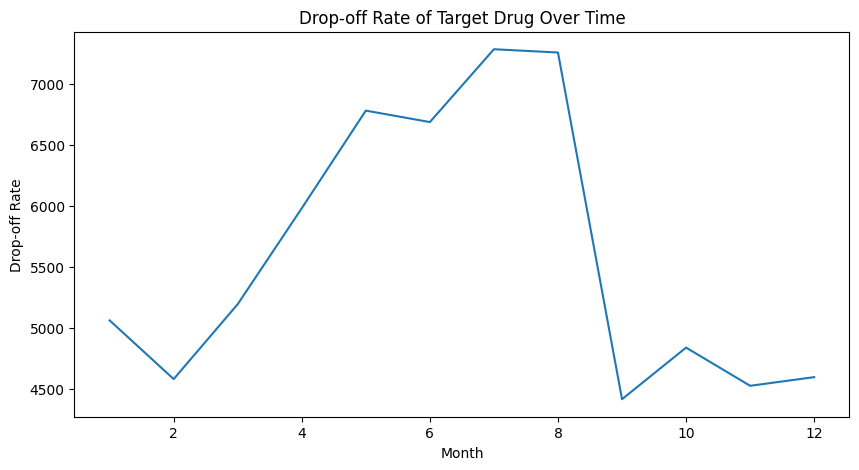

In [72]:
# Step 4: Visualize Drop-off Rate
plt.figure(figsize=(10, 5))
plt.plot(dropoff_count['Date'], dropoff_count['size'])
plt.xlabel('Month')
plt.ylabel('Drop-off Rate')
plt.title('Drop-off Rate of Target Drug Over Time')
plt.show()

In [124]:
df2 = df1.copy()

In [125]:
positive_set = df2[df2["Incident"] == 'TARGET DRUG'] #['Patient-Uid'].unique().tolist()

positive_set

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG
...,...,...,...
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG


In [126]:
reference_date = pd.to_datetime(df2["Date"]).max()

reference_date

Timestamp('2020-09-03 00:00:00')

In [139]:
negative_set = df2[df2['Incident'] != 'TARGET DRUG'] #& (reference_date - pd.to_datetime(df2["Date"]) >= pd.Timedelta(days=30))]

negative_set = negative_set.groupby('Patient-Uid').tail(1)

negative_set

,Patient-Uid,Date,Incident
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


In [140]:
# to get the count of previous prescriptions within specific time intervals
positive_set['Prescription_Count'] = positive_set.groupby('Patient-Uid')['Date'].cumcount()
negative_set['Prescription_Count'] = negative_set.groupby('Patient-Uid')['Date'].cumcount()

<ipython-input-140-bb28adb0773b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_set['Prescription_Count'] = positive_set.groupby('Patient-Uid')['Date'].cumcount()


In [141]:
# Step 3: Calculate Drop-off Rate
# Assuming ideal treatment duration for "Target Drug" is 1 year
#ideal_treatment_duration = pd.DateOffset(years=1)

In [142]:
positive_set['Time_Difference'] = (reference_date - positive_set.groupby('Patient-Uid')['Date'].transform(max)).dt.days
negative_set['Time_Difference'] = (reference_date - negative_set.groupby('Patient-Uid')['Date'].transform(max)).dt.days

<ipython-input-142-76ebbeb8c486>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_set['Time_Difference'] = (reference_date - positive_set.groupby('Patient-Uid')['Date'].transform(max)).dt.days


In [143]:
positive_set

,Patient-Uid,Date,Incident,Prescription_Count,Time_Difference
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,21
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,275
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,300
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,5
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,21
...,...,...,...,...,...
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG,4,541
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG,9,37
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG,10,14
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG,14,21


In [144]:
negative_set

,Patient-Uid,Date,Incident,Prescription_Count,Time_Difference
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS,0,851
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0,0,1976
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6,0,743
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2,0,744
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS,0,141
...,...,...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6,0,790
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6,0,979
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10,0,686
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6,0,1812


In [132]:
# prediction_date = pd.to_datetime('today') + pd.DateOffset(days=30)
# positive_set['Time_differ'] = (prediction_date - positive_set.groupby('Patient-Uid')['Date'].transform('max')).dt.days
# negative_set['Time_differ'] = (prediction_date - negative_set.groupby('Patient-Uid')['Date'].transform('max')).dt.days

In [146]:
new_df = pd.concat([positive_set, negative_set])
new_df

,Patient-Uid,Date,Incident,Prescription_Count,Time_Difference
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,21
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,275
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,300
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,5
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,21
...,...,...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6,0,790
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6,0,979
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10,0,686
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6,0,1812


In [147]:
new_df.columns

Index(['Patient-Uid', 'Date', 'Incident', 'Prescription_Count',
       'Time_Difference'],
      dtype='object')

In [160]:
# Step 4: Prepare Data for Logistic Regression
X = new_df[['Prescription_Count',
       'Time_Difference']]
y = new_df["Incident"] == 'TARGET DRUG'  # Assuming there's a column named "Dropoff" indicating whether a patient dropped off or not

# Step 5: Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train a Logistic Regression Model
model = XGBClassifier(booster='gbtree')
model.fit(X_train, y_train)

# Step 7: Evaluate the Model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.95      0.90      5354
        True       0.98      0.94      0.96     13497

    accuracy                           0.94     18851
   macro avg       0.92      0.94      0.93     18851
weighted avg       0.95      0.94      0.94     18851



In [171]:
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.9424964192881015


In [172]:
classes = ['Drop off','No Drop off']

# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

Test Confusion matrix


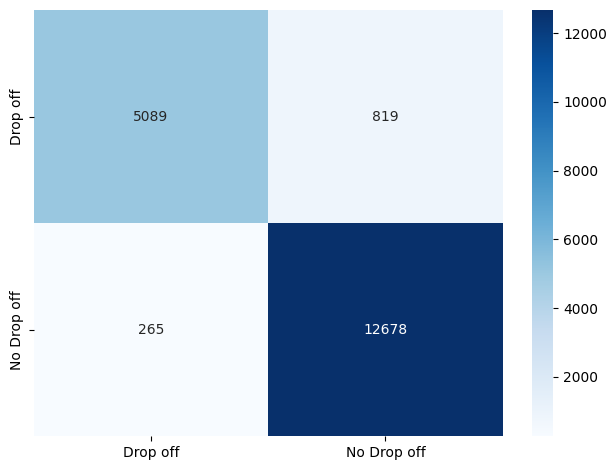

In [173]:
plot_confusionmatrix(y_pred,y_test,dom='Test')

Test set accuracy: 0.94
Test set auc: 0.94


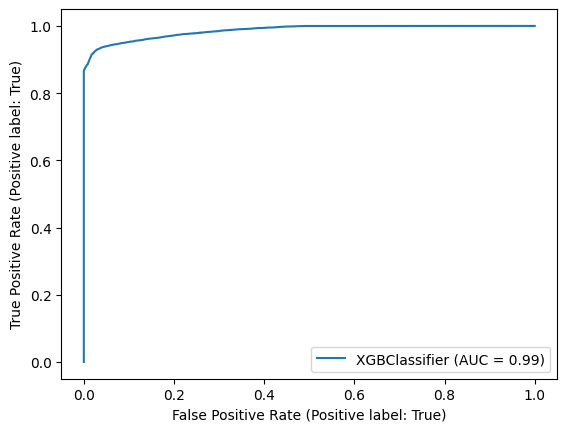

In [174]:
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
#we compute the eval metric on test/validation set only primarily

# Predict test set labels
y_pred = model.predict(X_test) # Model's predictions

# Compute test set accuracy
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))
acc = roc_auc_score(y_test, y_pred)
print("Test set auc: {:.2f}".format(acc))
RocCurveDisplay.from_estimator(model, X_test, y_test)


# acc = roc_auc_score(y_train, dt.predict(X_train))
# print("Train set AUC : ", acc)

### Step 8: Get Feature Importance

In [163]:
feature_importance = dict(zip(X.columns, model.feature_importances_))

### Step 9: Visualize Feature Importance

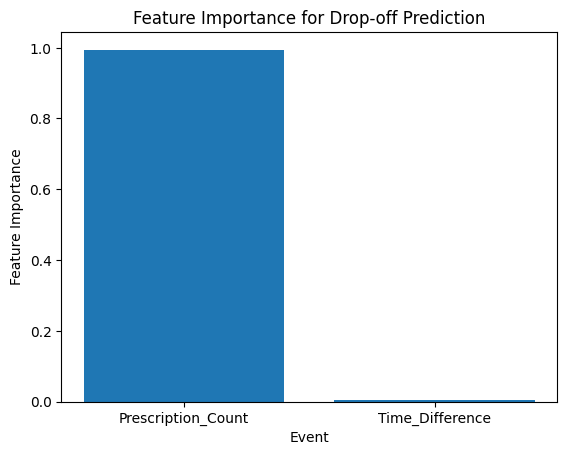

In [164]:
plt.bar(feature_importance.keys(), feature_importance.values())
plt.xlabel('Event')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Drop-off Prediction')
plt.show()

## Step 10: Interpretation and Insights
### Analyze the feature importance scores to identify the most influential events in predicting drop-off.
### Look for positive or negative coefficients indicating the direction of impact.
### For example, a positive coefficient for "Adverse_Event" means that patients with adverse events are more likely to drop off.
### Use the insights to understand which events are driving patients to stop taking the "Target Drug."

### Step 10: Interpretation and Insights
### Sort the feature importance scores in descending order

In [166]:
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

### Print the feature importance scores

In [168]:
print("Feature Importance Scores:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Feature Importance Scores:
Prescription_Count: 0.9947247505187988
Time_Difference: 0.005275243427604437


### Identify the most influential events driving drop-off

In [169]:
most_influential_event = sorted_feature_importance[0][0]
print(f"\nMost Influential Event in Drop-off Prediction: {most_influential_event}")


Most Influential Event in Drop-off Prediction: Prescription_Count


### Analyze the direction of impact

In [170]:
if feature_importance[most_influential_event] > 0:
    print(f"{most_influential_event} is positively correlated with drop-off.")
else:
    print(f"{most_influential_event} is negatively correlated with drop-off.")

Prescription_Count is positively correlated with drop-off.
